<a href="https://colab.research.google.com/github/TimWue/facialExpressionRecognition/blob/main/EmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-utils
!pip install opencv-python
!pip install tensorflow-datasets
!pip install --upgrade tensorflow
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip install tensorflowjs
!pip install alibi
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for opencv-utils: filename=opencv_utils-0.0.2-py3-none-any.whl size=6118 sha256=273cea6765fb44c542525546bf6f8fd49cd15f6f65ccaa683a0cf8f146ceeada
  Stored in directory: /root/.cache/pip/wheels/e3/74/9f/9ef97440159d9e5f126bc3b72594ad820eb64ca784cb48a3ea
Successfully built opencv-utils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 6.8 kB/s 
     |████████████████████████████████| 5.8 MB 55.8 MB/s 
     |████████████████████████████████| 438 kB 61.7 MB/s 
     |████████████████████████████████| 1.6 MB 53.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing install

In [ ]:
from os import listdir
import os
from PIL import Image as PImage
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD
import cv2
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten
import tensorflow_datasets as tfds
import glob
import zipfile
import tensorflowjs as tfjs
from sklearn.metrics import confusion_matrix
import seaborn as sns
from alibi.explainers import AnchorImage
import random
from typing import List
import visualkeras


%matplotlib inline

In [3]:
# Upload zip file with data manually BEFORE  executing the following
data_directory = 'fer2013'

files = glob.glob(data_directory + '.zip')
for file in files:
    print('Unzipping:',file)
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('./')


Unzipping: fer2013.zip


In [4]:
!nvidia-smi -L
tf.config.list_physical_devices('GPU')

GPU 0: Tesla T4 (UUID: GPU-01f9120d-7a99-a873-cf1c-11de9b529f5c)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
def showHistory(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')


In [6]:
def showDataOverview(train_labels, test_labels , class_names):
  assert(len(set(train_labels)) == len(set(train_labels)) & len(set(train_labels)) == len(class_names))

  bar_width = 0.8
  colors = plt.cm.BuPu(np.linspace(0.5, 1, 2))

  fig, ax = plt.subplots()
  plt.gcf().set_size_inches(8, 8)
  for index, class_name in enumerate(class_names):
    count_train_class = np.count_nonzero(train_labels == index)
    count_test_class = np.count_nonzero(test_labels == index)

    train_plot = plt.bar(index, count_train_class, bar_width, bottom=0, color = colors[0])
    test_plot = plt.bar(index, count_test_class, bar_width, bottom=count_train_class, color = colors[1])

  plt.title('Overview FER2013')
  ax.set_xticks(np.arange(len(class_names)))
  ax.set_xticklabels(class_names)
  ax.legend([train_plot,test_plot], ["Training", "Test"])
  plt.show()



In [7]:
def extractFaces(image_path, out_file, out_size):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
            gray,
            minNeighbors=3,
            flags=0,
            minSize=(0, 0)
    ) 

    for (x, y, w, h) in faces:
      # We want (almost) squared images
      try :
        if (w > h):
          diff = w - h
          newImg = image[x:x+w, y - round(diff / 2): y - round(diff / 2) + w]
        else:
          diff = h - w
          newImg = image[x - round(diff / 2): x- round(diff / 2) + h, y : y  + h]
        
        # resize image
        output = cv2.resize(newImg, out_size)
        cv2.imwrite(out_file, output)
      except:
        print("Error in face detection")



In [8]:
# Extract faces of images
def preprocess():
    data_base_path = "./"
    dataset_path = "fer2013/"
    processed_base_path = "new/"
    out_size = (48,48)

    base_path = data_base_path + dataset_path
    processed_path = data_base_path + processed_base_path

    first_level= listdir(base_path)

    if not os.path.exists(processed_path):
                os.makedirs(processed_path)

    for folder in first_level:
        second_level = listdir( base_path + folder)
        for emotionFolder in second_level:
            saveDirection = processed_path + folder + "/" + emotionFolder
            workingDirection = base_path + folder + "/" + emotionFolder
            images = listdir(workingDirection)
            print(workingDirection)
            if not os.path.exists(saveDirection):
                os.makedirs(saveDirection)
            for image in images:
                extractFaces(workingDirection + "/" + image, saveDirection + "/" + image, out_size)

In [9]:
# Preprocess the data if needed

PREPROCESS = False;

if (PREPROCESS):
  preprocess()
  zf = zipfile.ZipFile(data_directory + ".zip", "w")
  for dirname, subdirs, files in os.walk(data_directory):
      zf.write(dirname)
      for filename in files:
          zf.write(os.path.join(dirname, filename))
  zf.close()

In [10]:
# Show example image
def showOneImageOfDataset(dataset, toUint8, image_size_x = 48, image_size_y = 48, is_one_hot = False):
  for images, labels in dataset.take(1):
      first_image_of_batch = images.numpy()[0]
      first_label_of_batch = labels.numpy()[0]
      assert(image_size_x * image_size_y * 3 == first_image_of_batch.size)

      min_val = first_image_of_batch.min()
      max_val = first_image_of_batch.max()

      img = first_image_of_batch.reshape(image_size_x,image_size_y,3)

      if (toUint8):
        img = img.astype(np.uint8)

      title = ""

      if (is_one_hot):
        title = class_names[np.argmax(first_label_of_batch, axis=0)]
      else:
        title = class_names[first_label_of_batch]

      fig = plt.figure(frameon=False)
      plt.imshow(img,vmin=min_val,vmax=max_val, cmap="gray")
      plt.title(title)
      plt.colorbar()


In [11]:
def print_predictions(class_names, predictions):
  num_classes = len(class_names)
  for i in range(num_classes):
    print(f'{class_names[i]}: {"{:.2f}".format(100 * predictions[0][i])}%')

In [12]:
# Load data from directory
datasetBasePath = "./" + data_directory  
image_size_x = 48
image_size_y = 48
image_size = (image_size_x, image_size_y)
batch_size = 32
seed=1337

dataset_train = image_dataset_from_directory(
    datasetBasePath +"/train/", 
    image_size=image_size,
    seed=seed,
    batch_size=batch_size,
    shuffle=True
)

dataset_test = image_dataset_from_directory(
    datasetBasePath +"/test/", 
    image_size=image_size, 
    seed=seed,
    batch_size=batch_size,
    shuffle=True)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [13]:
class_names = dataset_train.class_names
num_classes = len(class_names)
input_shape=(image_size_x, image_size_y, 3)

print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


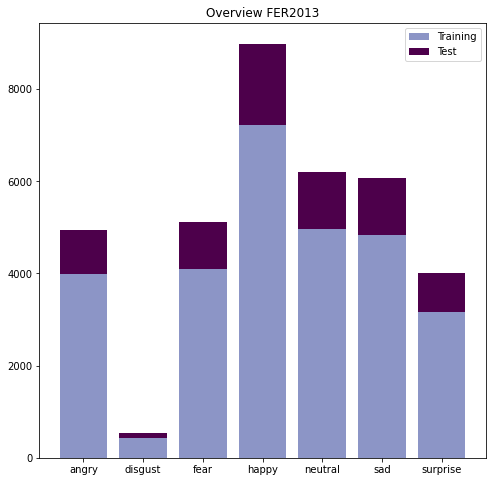

In [14]:
# Show overview
train_labels = y = np.concatenate([y for x, y in dataset_train], axis=0)
test_labels = y = np.concatenate([y for x, y in dataset_test], axis=0)
showDataOverview(train_labels,test_labels, class_names)

[238. 238. 238. ...  23.  23.  23.]


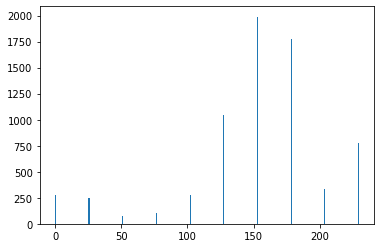

In [15]:
# Show some insights into data
all_data = iter(dataset_train.take(1)).next()[0][0].numpy().reshape(-1)
H, bins = np.histogram(all_data)

plt.bar(bins[:-1],H)
print(all_data)

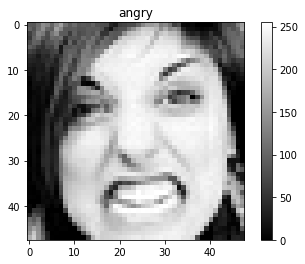

In [16]:
showOneImageOfDataset(dataset_train, True)

In [ ]:
# Some models, use just one

model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(image_size_x , image_size_y,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# verändert von https://blog.devgenius.io/facial-expression-recognition-with-tensorflow-90f6174163c3
# dauert lange !
#model = keras.Sequential([
#    layers.Rescaling(1./255, input_shape=(image_size_x , image_size_y, 3)),
#    tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.MaxPool2D(2),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.MaxPool2D(2),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
#    tf.keras.layers.MaxPool2D(2),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Flatten(),
#    layers.Dense(128, activation='relu'),
#    layers.Dense(num_classes)])


## from practical-cnn
#normalized_train = dataset_train.map(lambda image, label: (image / 255.0, label))
#normalized_test = dataset_test.map(lambda image, label: (image / 255.0, label))
#
#model = tf.keras.Sequential()
#model.add(Input(shape=input_shape))
#model.add(Conv2D(filters=32, kernel_size=2, activation='relu')) 
#model.add(MaxPooling2D(pool_size=2))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
#model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
#model.add(Dense(num_classes, activation='softmax'))

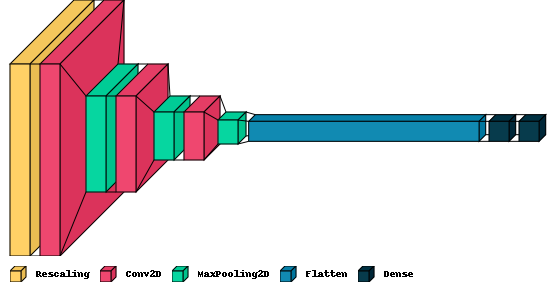

In [ ]:
visualkeras.layered_view(model, legend=True, to_file='overfitted_model_arch.png') # write to disk

In [ ]:
epochs=15

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
  dataset_train,
  validation_data=dataset_test,
  epochs=epochs
)

Epoch 1/15
898/898 [==============================] - 17s 13ms/step - loss: 1.6143 - accuracy: 0.3658 - val_loss: 1.4260 - val_accuracy: 0.4546
Epoch 2/15
898/898 [==============================] - 11s 12ms/step - loss: 1.3595 - accuracy: 0.4836 - val_loss: 1.3006 - val_accuracy: 0.5056
Epoch 3/15
898/898 [==============================] - 11s 12ms/step - loss: 1.2246 - accuracy: 0.5337 - val_loss: 1.2719 - val_accuracy: 0.5145
Epoch 4/15
898/898 [==============================] - 12s 13ms/step - loss: 1.1335 - accuracy: 0.5726 - val_loss: 1.2432 - val_accuracy: 0.5238
Epoch 5/15
898/898 [==============================] - 11s 13ms/step - loss: 1.0482 - accuracy: 0.6075 - val_loss: 1.2416 - val_accuracy: 0.5309
Epoch 6/15
898/898 [==============================] - 11s 12ms/step - loss: 0.9711 - accuracy: 0.6368 - val_loss: 1.3003 - val_accuracy: 0.5291
Epoch 7/15
898/898 [==============================] - 13s 14ms/step - loss: 0.8914 - accuracy: 0.6704 - val_loss: 1.3246 - val_accuracy:

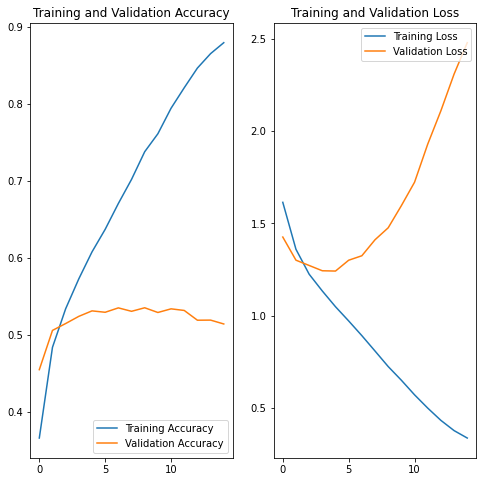

In [ ]:
showHistory(history,epochs)

Diese Plots zeigen Overfitting, deshalb muss dem entgegengewirkt werden. Hierfür werden zwei Änderungen eingeführt:
- Data-Augmentation: Leichtes Verändern der Input-Bilder um "genereller" zu lernen
- Dropout 

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=input_shape),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [18]:
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(48, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu' ),
  layers.Dense(num_classes,activation='softmax')
])

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
epochs=50
history = model.fit(
  dataset_train,
  validation_data=dataset_test,
  epochs=epochs
)

In [ ]:
# Load (manually upload model file before)
#model = keras.models.load_model('./model_22_08')


# Save (h5 format works best. for tensorflow.js we have to use a command line transformer)
# model.save('./')  # save in new format
# model.save('./model_22_08',save_format='h5') # save in old format which can be converted to tensorflowjs format
#tfjs.converters.save_keras_model(model, "./") # save directly in tensorflowjs format

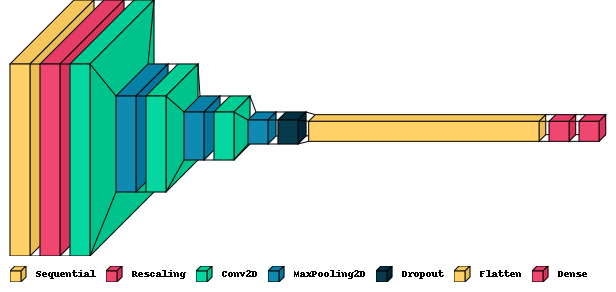

In [19]:
visualkeras.layered_view(model, legend=True, to_file='model_final.png') # write to disk

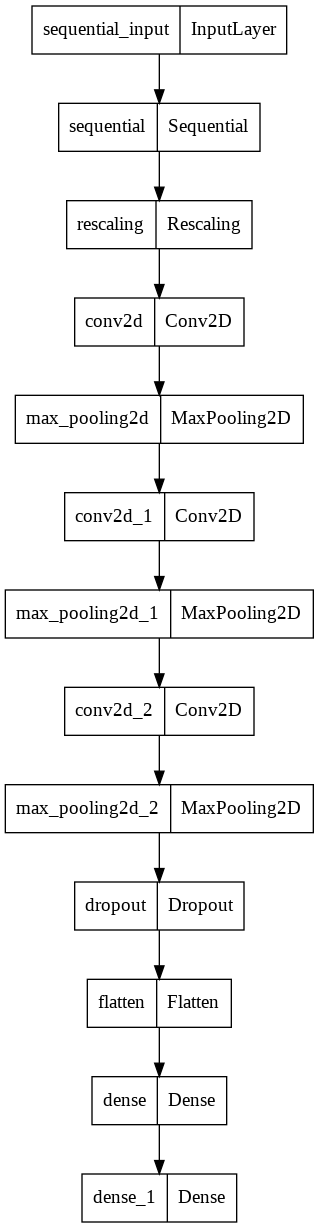

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)


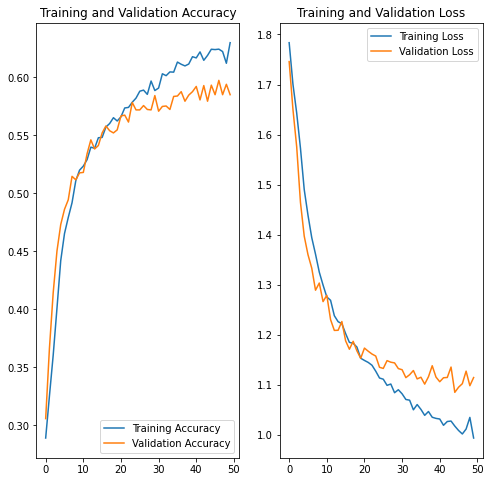

In [ ]:
showHistory(history,epochs)

In [ ]:
# Show some predictions (Depending on the dataset used, "files" must be edited because some file may have not survived preprocessing)

files = [
    "happy/PrivateTest_40251698",
    "angry/PrivateTest_2775163",
    "disgust/PrivateTest_4783181",
    "fear/PrivateTest_11251019",
    "neutral/PrivateTest_2134320",
    "sad/PrivateTest_16163666",
    "surprise/PrivateTest_3036992"
    ]

plt.gcf().set_size_inches(8, 9)

for index, currentFile in enumerate(files):    # add a new subplot iteratively
    img_path = "./" + data_directory +"/test/" + currentFile + ".jpg"
    img = tf.keras.preprocessing.image.load_img(
    img_path, target_size=image_size
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)
    max_index = predictions.argmax()

    ax = plt.subplot(3, 3, index + 1)
    emotion = currentFile.split('/')[0]
    plt.title("Truth: " + emotion + ",\n Pred.: " + class_names[max_index])
    plt.axis('off')
    ax.set_xlabel("")
    plt.imshow(img);


In [ ]:
# Take whole test dataset to evaluate predictions
sample_size = 7178
deterministic_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./" + data_directory +"/test/", 
    seed=seed,
    image_size=image_size,
    batch_size=sample_size,
    shuffle=True
).map(lambda image, label: (image, label))

val_image_batch, val_label_batch = next(iter(deterministic_val_ds))
y_pred = model.predict(val_image_batch).argmax(axis=1)
y_true = val_label_batch.numpy()


Found 2672 files belonging to 7 classes.
84/84 [==============================] - 4s 3ms/step


Show some wrong predictions

In [ ]:
predictions_wrong = y_pred != y_true
elements_wrong_predicted = [i for i, prediction_wrong in enumerate(predictions_wrong) if prediction_wrong]

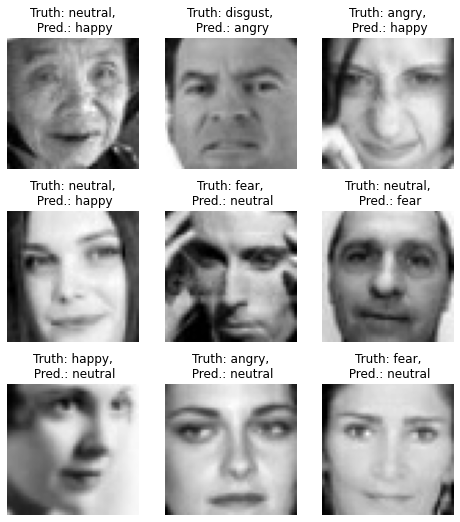

In [ ]:
random_wrong_elements = random.choices(elements_wrong_predicted, k=9)
plt.gcf().set_size_inches(8, 9)
for index, element in enumerate(random_wrong_elements):   
    truth = class_names[y_true[element]]
    prediction = class_names[y_pred[element]]
    ax = plt.subplot(3, 3, index + 1)
    plt.title("Truth: " + truth + ",\n Pred.: " + prediction)
    plt.axis('off')
    ax.set_xlabel("")
    img = tf.keras.utils.array_to_img(val_image_batch[element,:,:,:])
    plt.imshow(img)

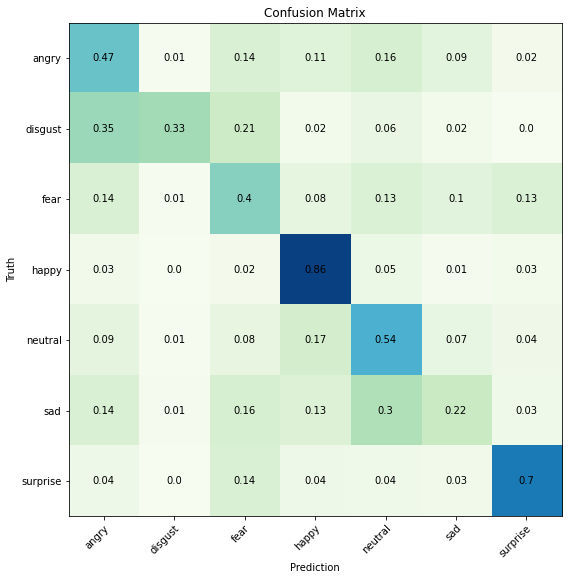

In [ ]:
# SHow confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize="true")

fig, ax = plt.subplots()
plt.gcf().set_size_inches(8, 9)

im = ax.imshow(cm,cmap="GnBu")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")


# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, round(cm[i, j],2),
                       ha="center", va="center", color="k")

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

###Normalisierung 
Wenn "normalize=true", dann wird bzgl der Truth values normalisiert. Heißt: die summe der Zahlen einer Reihe ergibt 1 (100%). Daraus kann man aussagen treffen wie: 15% aller "neutral" Bilder wurden als "angry predicted



In [ ]:
predict_fn = lambda x: model.predict(x)

1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.7/dist-packages/alibi/explainers/anchors/anchor_image.py:284: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.segmentation_fn(image_preproc)


4/4 [==============================] - 0s 5ms/step


/usr/local/lib/python3.7/dist-packages/alibi/explainers/anchors/anchor_image.py:45: RuntimeWarning: invalid value encountered in true_divide
  img_std = (image - img_min) / (img_max - img_min)


4/4 [==============================] - 0s 4ms/step


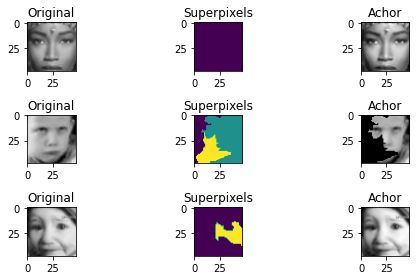

In [ ]:
#segmentation_fn = 'felzenszwalb'
#kwargs = {'scale': 700}

segmentation_fn = 'slic'
kwargs = {'n_segments': 25, 'compactness': 10, 'sigma': .5}

explainer = AnchorImage(predict_fn, (image_size_x,image_size_y,3))


np.random.seed(4)
fig, axes = plt.subplots(3, 3, figsize=(8, 4))
ax = axes.ravel()

for images, labels in dataset_train.take(1):
    for i in range(0,3):
        first_image_of_batch = images.numpy()[i]
        image= first_image_of_batch.reshape(image_size_x,image_size_y,3)
        original = image.astype(np.uint8)
        explanation = explainer.explain(image, threshold=.95, p_sample=.5, tau=0.25)
        axIndex = i*3       
        ax[axIndex].imshow(original,cmap="gray",vmin=0,vmax=255)
        ax[axIndex].set_title("Original")
        ax[axIndex+1].imshow(explanation.segments)
        ax[axIndex+1].set_title("Superpixels")
        ax[axIndex+2].imshow(explanation.anchor)
        ax[axIndex+2].set_title("Achor")
        fig.tight_layout()

plt.show()

#The following is all MobileNetV2 stuff (not working)



In [ ]:
def preprocess(images, labels):
  return tf.keras.applications.mobilenet_v2.preprocess_input(tf.image.resize(images,[224,224])), tf.one_hot(labels, num_classes)


In [ ]:
x_train =dataset_train.map(preprocess)
x_test = dataset_test.map(preprocess)

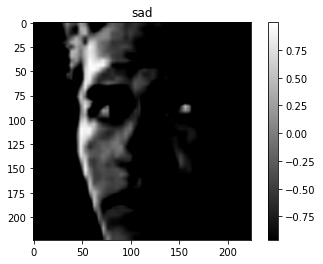

In [ ]:
showOneImageOfDataset(x_train, False, 224,224, True)

In [ ]:
model = tf.keras.applications.MobileNetV2(
    input_shape=(image_size_x,image_size_y,3),
    alpha=1.0,
    include_top = False,
    weights=None
)
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(48, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu' ),
  layers.Dense(num_classes,activation='softmax')
])

#model.add(layers.Flatten())
#model.add(layers.Dense(128, activation='relu' ))
#
#model.add(layers.Dense(num_classes,activation='softmax'))
#
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
#model.summary()
epochs=3
history = model.fit(
  x_train,
  validation_data=x_test,
  epochs=epochs
)


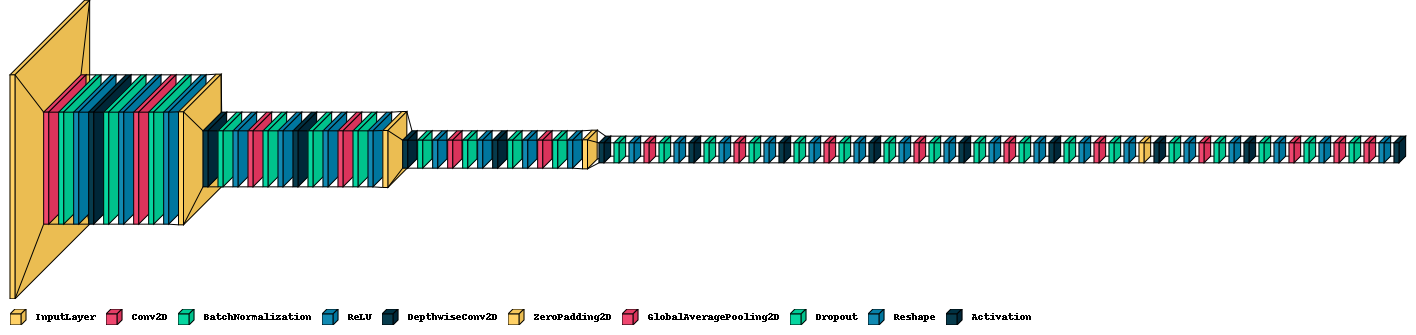

In [ ]:
model = tf.keras.applications.MobileNet()
visualkeras.layered_view(model, legend=True, to_file='mobilenet.png', scale_xy=1, scale_z=1, max_z=5) # write to disk



In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=True,
    weights='imagenet')

for layer in base_model.layers:
    layer.trainable = True  # trainable has to be false in order to freeze the layers

model = keras.Sequential([
  base_model,
  layers.Dense(128, activation='relu' ),
  layers.Dense(num_classes,activation='softmax')
])


model.compile(optimizer="adam",
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

epochs=20
history = model.fit(
  x_train,
  validation_data=x_test,
  epochs=epochs,
)


Epoch 1/20
898/898 [==============================] - 199s 217ms/step - loss: 1.6643 - accuracy: 0.3342 - val_loss: 2.1491 - val_accuracy: 0.2474
Epoch 2/20
898/898 [==============================] - 197s 220ms/step - loss: 1.4355 - accuracy: 0.4293 - val_loss: 1.7534 - val_accuracy: 0.3381
Epoch 3/20
898/898 [==============================] - 199s 222ms/step - loss: 1.3383 - accuracy: 0.4707 - val_loss: 1.8403 - val_accuracy: 0.3879
Epoch 4/20
898/898 [==============================] - 198s 221ms/step - loss: 1.2496 - accuracy: 0.5213 - val_loss: 1.8947 - val_accuracy: 0.3260
Epoch 5/20
898/898 [==============================] - 198s 220ms/step - loss: 1.1700 - accuracy: 0.5468 - val_loss: 1.7256 - val_accuracy: 0.4189
Epoch 6/20
898/898 [==============================] - 199s 221ms/step - loss: 1.1056 - accuracy: 0.5777 - val_loss: 1.6098 - val_accuracy: 0.4430
Epoch 7/20
898/898 [==============================] - 198s 220ms/step - loss: 1.0493 - accuracy: 0.6035 - val_loss: 1.5377 -

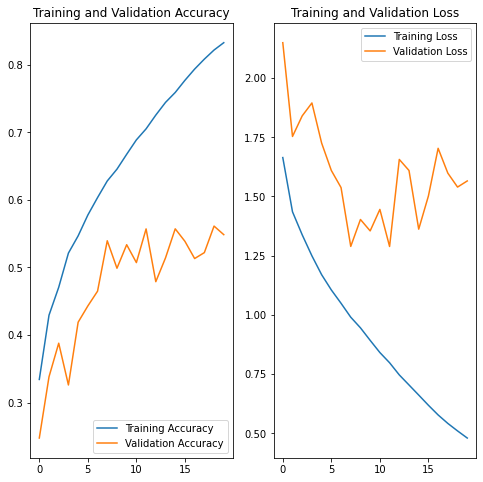

In [ ]:
showHistory(history,epochs)